# Markov-Chain Monte Carlo (MCMC)

## Lotka-Volterra Model
    

\begin{equation}
\begin{split}
\frac{dx}{dt} =&  v-v^3-w+I_{ext}\\
\frac{dy}{dt} =& \frac{1}{\tau}(v-a-bw)
\end{split}
\end{equation}

In [1]:
import argparse
import os


import matplotlib
import matplotlib.pyplot as plt

from jax.experimental.ode import odeint
import jax.numpy as jnp
from jax.random import PRNGKey

import numpyro
import numpyro.distributions as dist
from numpyro.examples.datasets import LYNXHARE, load_dataset
from numpyro.infer import MCMC, NUTS, Predictive


In [2]:

def dz_dt(z, t, theta):
    """
    Lotka–Volterra equations. Real positive parameters `alpha`, `beta`, `gamma`, `delta`
    describes the interaction of two species.
    """
    u = z[0]
    v = z[1]
    alpha, beta, gamma, delta = theta[..., 0], theta[..., 1], theta[..., 2], theta[..., 3]
    du_dt = (alpha - beta * v) * u
    dv_dt = (-gamma + delta * u) * v

    return jnp.stack([du_dt, dv_dt])


def model(N, y=None):
    """
    :param int N: number of measurement times
    :param numpy.ndarray y: measured populations with shape (N, 2)
    """
    # initial population
    z_init = numpyro.sample("z_init", dist.LogNormal(jnp.log(10), 1), sample_shape=(2,))
    # measurement times
    ts = jnp.arange(float(N))
    # parameters alpha, beta, gamma, delta of dz_dt
    theta = numpyro.sample(
        "theta",
        dist.TruncatedNormal(low=0., loc=jnp.array([0.5, 0.05, 1.5, 0.05]),
                             scale=jnp.array([0.5, 0.05, 0.5, 0.05])))
    # integrate dz/dt, the result will have shape N x 2
    z = odeint(dz_dt, z_init, ts, theta, rtol=1e-5, atol=1e-3, mxstep=500)

    # measurement errors, we expect that measured hare has larger error than measured lynx 
    sigma = numpyro.sample("sigma", dist.Exponential(jnp.array([1, 2])))

    # measured populations (in log scale)
    numpyro.sample( "y" , dist.Normal(jnp.log(z), sigma), obs=y)


In [7]:
device = 'cpu'

num_samples = 1000
num_chains = 2
num_warmup = 200

numpyro.set_platform(device)
numpyro.set_host_device_count(num_chains)


_, fetch = load_dataset(LYNXHARE, shuffle=False)
year, data = fetch()  # data is in hare -> lynx order

# use dense_mass for better mixing rate
mcmc = MCMC(NUTS(model, dense_mass=True),
            num_warmup, num_samples, num_chains=num_chains, progress_bar= True)
mcmc.run(PRNGKey(1), N=data.shape[0], y=jnp.log(data))
mcmc.print_summary()


sample: 100%|██████████| 2000/2000 [17:04<00:00,  1.95it/s, 1023 steps of size 4.44e-11. acc. prob=0.80]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma[0]      0.52      0.00      0.52      0.52      0.52      0.50      1.00
  sigma[1]      0.58      0.00      0.58      0.58      0.58      0.50      1.00
  theta[0]      3.72      0.00      3.72      3.72      3.72      0.50      1.00
  theta[1]      0.84      0.00      0.84      0.84      0.84      0.50      1.00
  theta[2]      1.55      0.00      1.55      1.55      1.55      0.50      1.00
  theta[3]      4.53      0.00      4.53      4.53      4.53      0.50      1.00
 z_init[0]     18.89      0.00     18.89     18.89     18.89      0.50      1.00
 z_init[1]     19.14      0.00     19.14     19.14     19.14      0.50      1.00

Number of divergences: 0


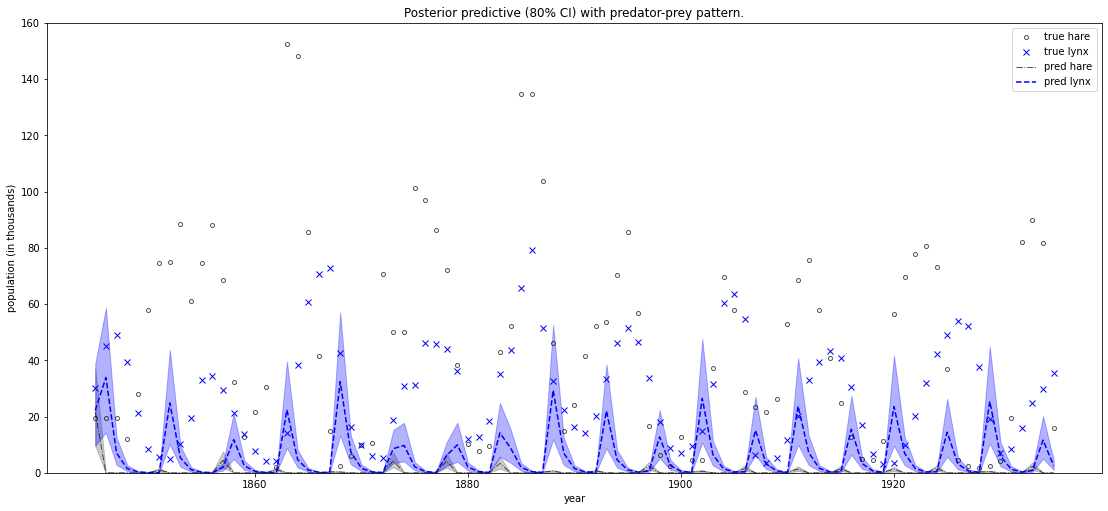

In [9]:
# predict populations
ax = plt.figure(figsize=(15.5, 7.2))
y_pred = Predictive(model, mcmc.get_samples())(PRNGKey(2), data.shape[0])["y"]
pop_pred = jnp.exp(y_pred)
mu, pi = jnp.mean(pop_pred, 0), jnp.percentile(pop_pred, (10, 90), 0)
plt.plot(year, data[:, 0], "ko", mfc="none", ms=4, label="true hare", alpha=0.67)
plt.plot(year, data[:, 1], "bx", label="true lynx")
plt.plot(year, mu[:, 0], "k-.", label="pred hare", lw=1, alpha=0.67)
plt.plot(year, mu[:, 1], "b--", label="pred lynx")
plt.fill_between(year, pi[0, :, 0], pi[1, :, 0], color="k", alpha=0.2)
plt.fill_between(year, pi[0, :, 1], pi[1, :, 1], color="b", alpha=0.3)
plt.gca().set(ylim=(0, 160), xlabel="year", ylabel="population (in thousands)")
plt.title("Posterior predictive (80% CI) with predator-prey pattern.")
plt.legend()
plt.tight_layout()
plt.show()


In [29]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma[0]      0.52      0.00      0.52      0.52      0.52      0.50      1.00
  sigma[1]      0.58      0.00      0.58      0.58      0.58      0.50      1.00
  theta[0]      3.72      0.00      3.72      3.72      3.72      0.50      1.00
  theta[1]      0.84      0.00      0.84      0.84      0.84      0.50      1.00
  theta[2]      1.55      0.00      1.55      1.55      1.55      0.50      1.00
  theta[3]      4.53      0.00      4.53      4.53      4.53      0.50      1.00
 z_init[0]     18.89      0.00     18.89     18.89     18.89      0.50      1.00
 z_init[1]     19.14      0.00     19.14     19.14     19.14      0.50      1.00

Number of divergences: 0


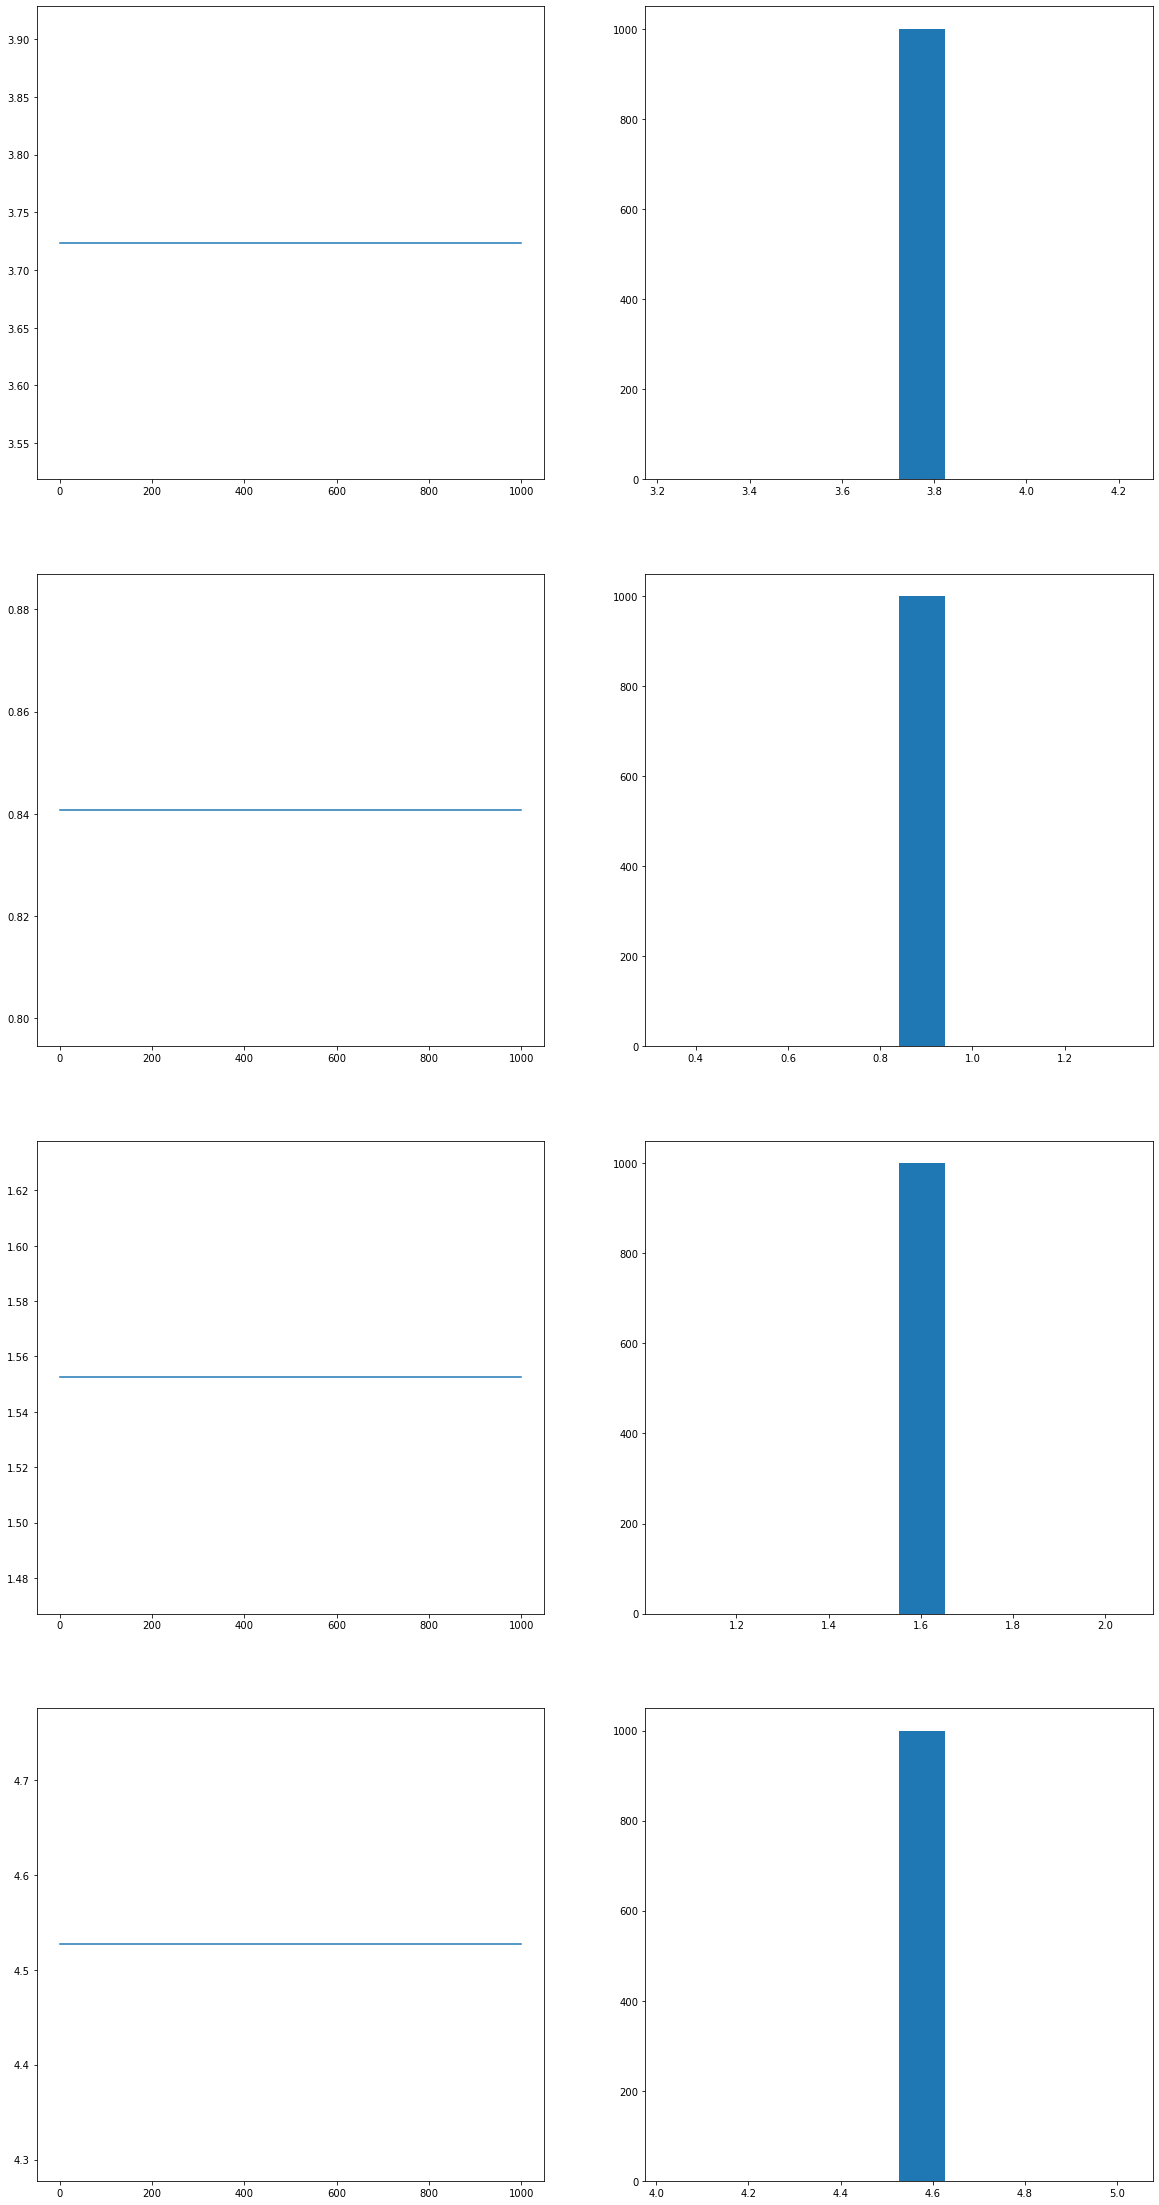

In [22]:
params = mcmc.get_samples()['theta']

fig, ax = plt.subplots(4,2, figsize=(20, 40))

ax[0,0].plot(params[:num_samples,0]), ax[0,1].hist(params[:num_samples,0])
ax[1,0].plot(params[:num_samples,1]), ax[1,1].hist(params[:num_samples,1])
ax[2,0].plot(params[:num_samples,2]), ax[2,1].hist(params[:num_samples,2])
ax[3,0].plot(params[:num_samples,3]), ax[3,1].hist(params[:num_samples,3])

for i in range(4):
    ax[i,0].set_title('Trace plot')
    ax[i,0].set_xlabel('Chain Iter')
    ax[i,1].set_ylabel('Value')
    ax[i,1].set_ylabel('Freq')

plt.show()

In [24]:
params.all

(1000, 4)